<footer id="footer"></footer>

[DETECTRON2](https://github.com/facebookresearch)

<img src="https://i.ibb.co/M2LF2GQ/image.png" alt="image" border="0">

## Контекст


Задача нахождения объектов на изображении может быть поставлена различным образом и включает в себя класс других задач, помогающих определить, какие объекты находятся на изображении и где они расположены в сетке пикселей исходного изображения.  

Задача семантической сегментации (англ. semantic segmentation) — задача, в которой на вход модели подаётся изображение, а на выходе для каждого пикселя является метка принадлежности этого пикселя к определённой категории. Например, если в исходном изображении человек переходит дорогу, то для каждого пикселя необходимо вывести, является ли этот пиксель частью человеческого тела, профиля дороги, знака дорожного движения, неба, или какого-то другого типа. Существенный недостаток применения одной лишь семантической сегментации относительно задач, связанных с распознаванием объектов — маркировка пикселей по принадлежности только к типу объекта, что не создаёт различия между объектами как таковыми. Например, если назвать "объектом" связную область пикселей, характеризующих одинаковый тип, то два объекта, перегораживающих друг друга на исходном изображении, будут определены как один объект, что в корне неверно. Задача семантической сегментации изображения с дифференцированием объектов называется задачей сегментации экземпляров (англ. instance segmentation). Модели, решающие задачу сегментации экземпляров, применяются, в том числе, для подсчёта людей в массовых скоплениях, для автомобилей с автоматическим управлением.  

Задача классификации с локализацией (англ. classification and localization) — задача, в которой в дополнение к предсказанию метки категории класса определяется рамка, ограничивающая местоположение экземпляра одиночного объекта на картинке. Как правило, рамка имеет прямоугольную форму, её стороны ориентированы параллельно осям исходного изображения, а площадь является минимальной при условии полного нахождения экземпляра объекта внутри этой рамки. Такую прямоугольную рамку называют термином "ограничивающая рамка" (англ. bounding box). Ограничивающую рамку можно задать как при помощи центра, ширины и высоты, так и при помощи четырёх сторон. Модель в данном случается одновременно обучается как верной классификации, так и максимально точному определению границ рамки.  

Задача детекции объектов (англ. object detection) — задача, в рамках которой необходимо выделить несколько объектов на изображении посредством нахождения координат их ограничивающих рамок и классификации этих ограничивающих рамок из множества заранее известных классов. В отличие от классификации с локализацией, число объектов, которые находятся на изображении, заведомо неизвестно.  [[1]](https://neerc.ifmo.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BD%D0%B0%D1%85%D0%BE%D0%B6%D0%B4%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8)

В данном ноутбуке представлен baseline обучения детектора с помощью detectron2 на кастомном дата сете

In [ ]:
%%capture
!pip install pyyaml==5.1

In [ ]:
%%capture
# after firstr run - restart runtime
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


# Импорт библиотек

Выше, мы установили в ноутбук детектро2. После завершения ячейки - вам необходимо перезапустить runtime. Теперь мы можем импортировать необходимые библиотеки

In [ ]:
import os
import cv2
import random
import torchvision
import json
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode
from detectron2.engine.defaults import DefaultPredictor

Проверим, что у нас активно GPU

In [ ]:
torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device(type='cuda')

Скачаем подготовленный сет - размечали его в [supervise.ly](https://supervise.ly/) - достаточно удобный инструмент, если вам необходимо быстро разметить ваши данные

<img src="https://i.ibb.co/WtjfgHG/image.jpg" alt="image" border="0">

In [ ]:
!gdown --id 1Qrf-OOzq6BihGu9UVDtDtp9ANiBxJBLy

Downloading...
From: https://drive.google.com/uc?id=1Qrf-OOzq6BihGu9UVDtDtp9ANiBxJBLy
To: /content/weapon_data.tar
100% 17.3M/17.3M [00:00<00:00, 65.6MB/s]


In [ ]:
!tar -xvf "/content/weapon_data.tar" 

tar: Removing leading `/' from member names
/
data/
data/annotations/
data/annotations/instances.json
data/images/
data/images/004eb6ca27183afe.jpg
data/images/006fb86aed487201.jpg
data/images/00ad97c5dffb2e4c.jpg
data/images/00d1e939c70f17f0.jpg
data/images/01ef51c8344a2332.jpg
data/images/02d5df929d1d4c8a.jpg
data/images/02eff940ae3f0189.jpg
data/images/02ffeebafd3a40e6.jpg
data/images/05a0dd0133e1c360.jpg
data/images/0a8e3feb4b51c755.jpg
data/images/0ae415b04565a42f.jpg
data/images/0bd63662e7cd0810.jpg
data/images/0c2b9173cbf4371c.jpg
data/images/0c49a929b8ca1778.jpg
data/images/0c705b3c60defa24.jpg
data/images/0caad617044daefb.jpg
data/images/0d3f3f4e0634026b.jpg
data/images/0da26d8c48db43f7.jpg
data/images/0daf487fefb94a84.jpg
data/images/0e1ce89d9756eaaa.jpg
data/images/0e42733e2e82b4a2.jpg
data/images/0e4e393b86a1224b.jpg
data/images/0edfdd96b6112b41.jpg
data/images/0f094ee4f9c791b9.jpg
data/images/0f22eaf0d420239f.jpg
data/images/0f9cde9b86c937f5.jpg
data/images/0fb59014e6cdabb

Для того, чтобы работать с сетом - необходимо его зарегистрировать для детектрона2 - делается это достаточно просто:

In [ ]:
register_coco_instances("weapon_coco_swords", {}, "/content/data/annotations/instances.json", "/content/data/images")

Теперь создадим объект - метадата - он будет содержать наши лейблы и другую информацию, в стиле COCO сетов

In [ ]:
metadata = MetadataCatalog.get("weapon_coco_swords")

In [ ]:
dataset_dicts = DatasetCatalog.get("weapon_coco_swords")

[12/26 14:44:22 d2.data.datasets.coco]: Loaded 80 images in COCO format from /content/data/annotations/instances.json


Посмотрим на объект из сета:

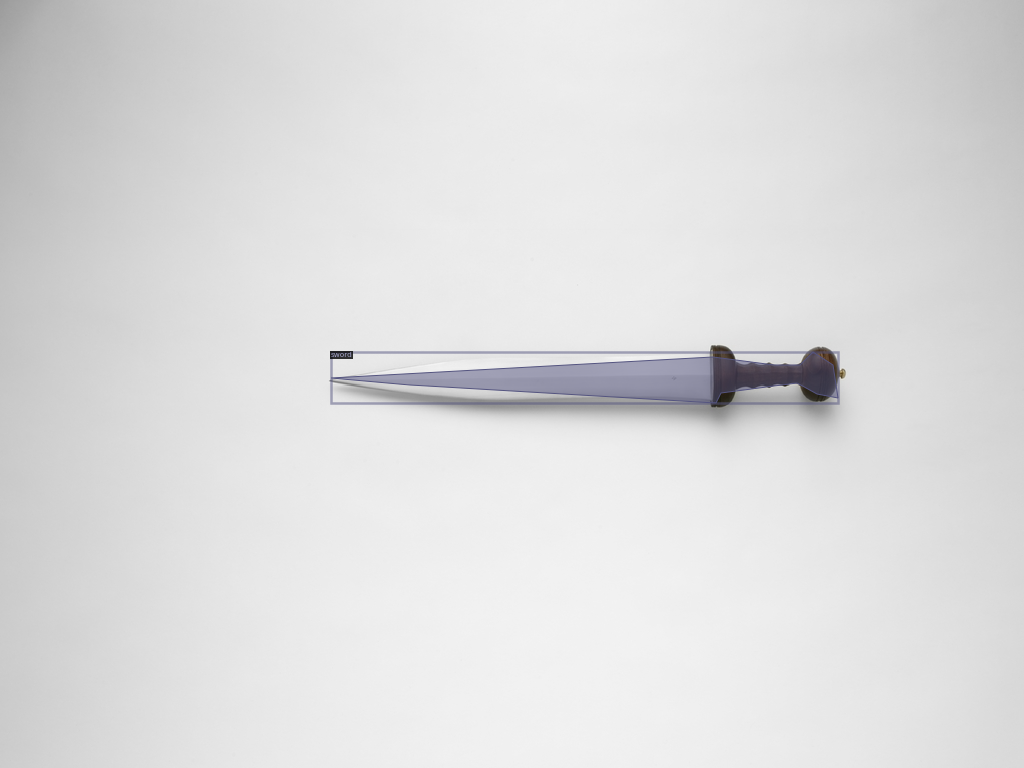

In [ ]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


Все готово к обучению - выбираем модель из зоопарка, указываем сет и другие параметры обучения, указываем количество классов - `cfg.MODEL.ROI_HEADS.NUM_CLASSES`

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("weapon_coco_swords",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 3e-4
cfg.SOLVER.MAX_ITER = (
    500
) 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/26 14:45:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[12/26 14:45:43 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[12/26 14:45:48 d2.utils.events]:  eta: 0:02:05  iter: 19  total_loss: 2.248  loss_cls: 1.098  loss_box_reg: 0.4078  loss_mask: 0.6846  loss_rpn_cls: 0.009506  loss_rpn_loc: 0.01299  time: 0.2650  data_time: 0.0193  lr: 1.1689e-05  max_mem: 3633M
[12/26 14:45:54 d2.utils.events]:  eta: 0:02:04  iter: 39  total_loss: 1.979  loss_cls: 0.8639  loss_box_reg: 0.4033  loss_mask: 0.6641  loss_rpn_cls: 0.004163  loss_rpn_loc: 0.0148  time: 0.2751  data_time: 0.0120  lr: 2.3677e-05  max_mem: 3633M
[12/26 14:45:59 d2.utils.events]:  eta: 0:01:57  iter: 59  total_loss: 1.719  loss_cls: 0.5955  loss_box_reg: 0.464  loss_mask: 0.6171  loss_rpn_cls: 0.009045  loss_rpn_loc: 0.01356  time: 0.2724  data_time: 0.0111  lr: 3.5665e-05  max_mem: 3633M
[12/26 14:46:05 d2.utils.events]:  eta: 0:01:55  iter: 79  total_loss: 1.354  loss_cls: 0.3588  loss_box_reg: 0.3853  loss_mask: 0.5583  loss_rpn_cls: 0.004265  loss_rpn_loc: 0.02352  time: 0.2739  data_time: 0.0089  lr: 4.7653e-05  max_mem: 3723M
[12/26 14:4

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


Модель обучилась. Этот код позволяет запустить tensorboard для изучения кривых обучения и других характеристик

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


Теперь, мы загружаем веса обученной модели - их необходимо будет сохранить, если вы хотите использовать модель локально или в web

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.DATASETS.TEST = ("weapon_coco_swords", )
predictor = DefaultPredictor(cfg)

и вот, мы получаем предсказания

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


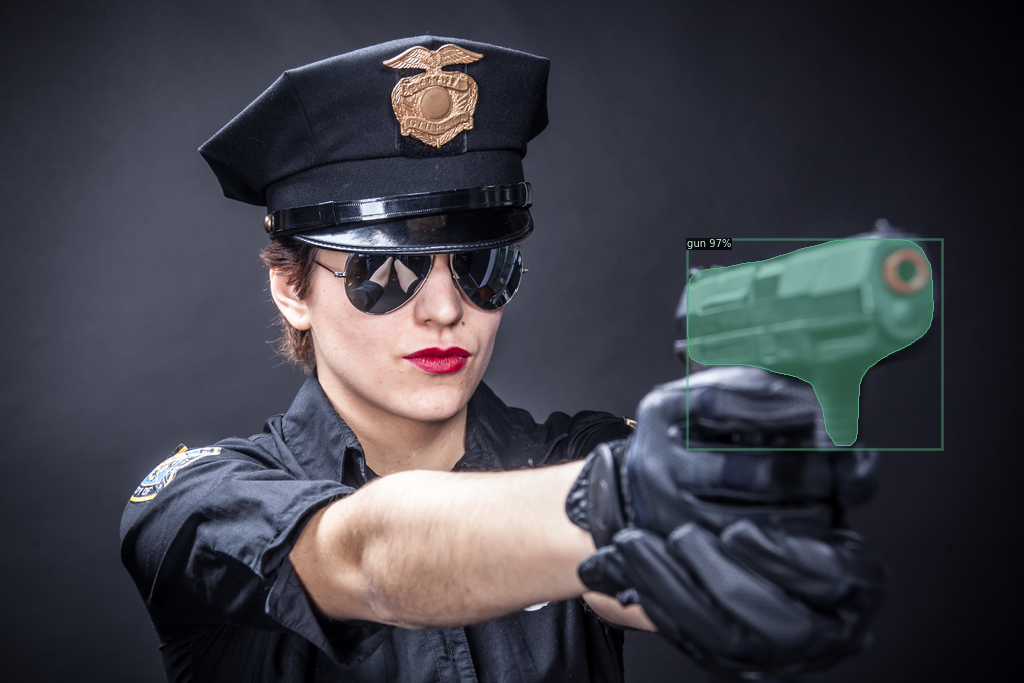

In [ ]:
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=1
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


Теперь, сохраним конфигурацию нашей модели и нашу модель

In [ ]:
with open("/content/output/config.yaml", "w") as f:
    f.write(cfg.dump())

import shutil
shutil.make_archive('custom_model', 'zip', '/content/output')

'/content/custom_model.zip'